In [3]:

.libPaths()

[1] "C:/Users/dev/Documents/R/win-library/3.5"
[2] "C:/Program Files/R/R-3.5.0/library"

In [6]:

install.packages('dplyr')
library(dplyr)
install.packages('reshape2')
library(reshape2)
install.packages('ggplot2')
library(ggplot2)

Installing package into 'C:/Users/dev/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
Warning message:
"package 'dplyr' is in use and will not be installed"Installing package into 'C:/Users/dev/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
Warning message:
"package 'reshape2' is in use and will not be installed"Installing package into 'C:/Users/dev/Documents/R/win-library/3.5'
(as 'lib' is unspecified)
also installing the dependencies 'colorspace', 'RColorBrewer', 'dichromat', 'munsell', 'labeling', 'viridisLite', 'gtable', 'scales', 'lazyeval'



package 'colorspace' successfully unpacked and MD5 sums checked
package 'RColorBrewer' successfully unpacked and MD5 sums checked
package 'dichromat' successfully unpacked and MD5 sums checked
package 'munsell' successfully unpacked and MD5 sums checked
package 'labeling' successfully unpacked and MD5 sums checked
package 'viridisLite' successfully unpacked and MD5 sums checked
package 'gtable' successfully unpacked and MD5 sums checked
package 'scales' successfully unpacked and MD5 sums checked
package 'lazyeval' successfully unpacked and MD5 sums checked
package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\dev\AppData\Local\Temp\Rtmp23E8gA\downloaded_packages


In [13]:

DataPath="../data/csv/" # you may need to update this if not working from same path
setwd(DataPath)


# Data from version 2.0 of covariates and pooled score estimates from SEDA
# https://cepa.stanford.edu/seda/data-archive

In [14]:

list.files()

[1] "coinbaseUSD.csv"               "SEDA_cov_geodist_pool_v20.csv"
[3] "SEDA_geodist_pool_CS_v20.csv"

In [15]:

# https://stacks.stanford.edu/file/druid:db586ns4974/SEDA_geodist_pool_CS_v20.csv
sedaScores = read.csv("SEDA_geodist_pool_CS_v20.csv",stringsAsFactors = F)

In [16]:

# https://stacks.stanford.edu/file/druid:db586ns4974/SEDA_cov_geodist_pool_v20.csv
# (This one is pooled by across years and grades)
sedaCovars=read.csv("SEDA_cov_geodist_pool_v20.csv",stringsAsFactors = F)


# 1: merge scores and covariate data
# 2: retain only rows with mean for all students (not disaggregated by race/ethnicity)
# 3: duplicate some columns with easier to find name and some combinations

In [17]:

sedaMerged = merge(sedaScores,sedaCovars,by='leaidC') %>%
  filter(
    subgroup=='all'
  ) %>%
  mutate(
    score=mn_avg_ol, 
    expenditure_total = ppexp_tot,
    expenditure_instructional = ppexp_inst,
    revenue=pprev_tot,
    state=stateabb.y,
    enrollment=totenrl,
    pct_white_or_asian =perasn+perwht,
    pct_underrepresented_minority=perblk + perind + perhsp,
    median_income=inc50all,
    pct_ba_or_higher = baplus_all,
    pct_single_mom=singmom_all,
    SES=sesall,
    pct_special_ed = perspeced,
    median_income_10k = median_income / 10000
  )


# I included some extra variables I'm not using in this brief example but have used for related analysis

In [18]:

# 'melt' selected expenditure measures so that we can analyze them quickly via grouping
sedaMelted = sedaMerged %>%
  mutate(
    log_income=log(inc50all),
    `total expenditure per pupil`=expenditure_total,
    `instructional expenditure per pupil`=expenditure_instructional,
    `revenue per pupil`=revenue
  ) %>%
  melt(
    measure.vars=c(
      'total expenditure per pupil',
      'instructional expenditure per pupil',
      'revenue per pupil'
    )
  )

In [19]:

# group by state and fiscal variables
sedaCors = sedaMelted %>%
  group_by(state,variable) %>%
  mutate(
    n=n()
  ) %>%
  filter(
    n > 3  # exclude groups with fewer than 3 rows since this causes errors
           # in this case, excludes groups with DC as a 'state' since it only 1 school district
  ) %>%
  summarise(
    cor=cor.test(value,score)$estimate,
    cor_lo=cor.test(value,score)$conf.int[1],
    cor_hi=cor.test(value,score)$conf.int[2],
    enrollment=sum(enrollment,na.rm=T)
  ) %>%
  ungroup()

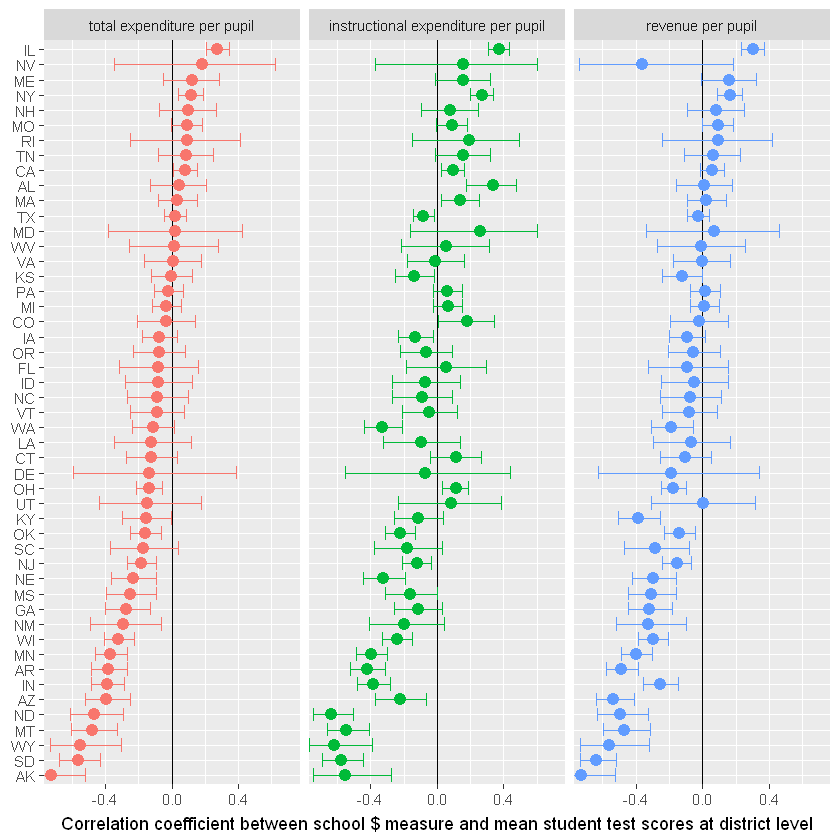

In [20]:

sedaCors %>%
  group_by(variable) %>%
  mutate(
    # create factor for state, ordered by mean correlation
    state_lab=reorder(state,cor,mean,na.rm=T) 
  ) %>%
  ungroup() %>% {
    
    ggplot(.,aes(cor,state_lab,color=variable)) +
      geom_vline(xintercept=0) +
      geom_point(size=3) +
      geom_errorbarh(aes(xmin=cor_lo,xmax=cor_hi)) +
      facet_wrap(~ variable,ncol=3) +
      theme(legend.position='none') +
      labs(
        y=NULL,
        x='Correlation coefficient between school $ measure and mean student test scores at district level'
      ) +
      coord_cartesian(xlim=c(-.7,.7))
  }